# Neural Network

## Importing Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler

In [36]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [37]:
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LeakyReLU,PReLU,ELU
# from keras.layers import Dropout

## Loading Dataset

In [38]:
df = pd.read_csv('heart.csv')
data = df.to_numpy()

In [39]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [40]:
X = data[:, :-1]
# y = data[:, -1]
y = data[:, -1].reshape((-1,1))

## **Data Preprocessing**
### Spliting Dataset

We split our dataaset into 60% training set and 40% testing set. Then we further split the training set into 70% training and 30% validation set

In [41]:
# Split data into training and testing sets (60% training, 40% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split training data into training and validation sets (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [42]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (126, 13)
X_val shape: (55, 13)
X_test shape: (122, 13)
y_train shape: (126, 1)
y_val shape: (55, 1)
y_test shape: (122, 1)


### Scaling Data

In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform validation and testing data using the scaler fitted on the training data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## **Implementation Of Neural Network Using Pytorch**

In [44]:
%conda install -c pytorch pytorch torchvision

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0




In [45]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, BCELoss
from torch.optim import SGD
import matplotlib.pyplot as plt

### Convert numpy arrays to PyTorch tensors

In [46]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

### Defining Neural Network Class

In [47]:
def get_act_fn(act_fn):
    if act_fn == 'relu':
        return F.relu
    elif act_fn == 'sigmoid':
        return F.sigmoid
    elif act_fn == 'tanh':
        return F.tanh
    raise ValueError


class model(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, activation='sigmoid', out_activation='sigmoid'):
        super(model, self).__init__()
        self.linear1 = Linear(n_feature, n_hidden, bias=True)
        self.linear2 = Linear(n_hidden, n_output, bias=True)
        # Activation functions
        self.activation = get_act_fn(activation)
        self.output_activation = get_act_fn(out_activation)
 
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.output_activation(self.linear2(x))
        return x

## **Training Our Neural Network Model**

### Training with default Sigmoid activation function first

In [48]:
train_model = model(X_train.shape[1], 8, 1)
loss_cal = BCELoss(reduction='mean')

### Optimization with Stochastic Gradient Descent

In [49]:
def optimize(num_epoch, optimizer, model, X_tensor, y_tensor):
    epoch_loss_dict = {}
    for epoch in range(num_epoch):                    
        y_pred = model(X_tensor)                    # Forward propagation
        loss = loss_cal(y_pred, y_tensor)           # Compute lost
        epoch_loss_dict[epoch] = loss.item()
        optimizer.zero_grad()                       # Zero the gradients
        loss.backward()                             # Backward propagation
        optimizer.step()                            # Update the parameters

    return y_pred, epoch_loss_dict


num_epoch = 10000
optimizer = SGD(train_model.parameters(), lr=0.01)

y_pred_train, epoch_loss_dict_train = optimize(num_epoch, optimizer, train_model, X_train_tensor, y_train_tensor)

In [50]:
y_pred_binary_train = (y_pred_train.detach().numpy() > 0.5).astype(int)

### **Training Results**

#### Performance Metrics

In [51]:
def perf_metrics(y, y_pred_binary):
    accuracy = accuracy_score(y, y_pred_binary)
    precision = precision_score(y, y_pred_binary)
    recall = recall_score(y, y_pred_binary)
    f1 = f1_score(y, y_pred_binary)
    return accuracy, precision, recall, f1


accuracy_train, precision_train, recall_train, f1_train = perf_metrics(y_train, y_pred_binary_train)
print("Accuracy on training set:", accuracy_train)
print("Precision on training set:", precision_train)
print("Recall on training set:", recall_train)
print("F1-score on training set:", f1_train)

Accuracy on training set: 0.9047619047619048
Precision on training set: 0.90625
Recall on training set: 0.90625
F1-score on training set: 0.90625


#### Plotting Loss Curve

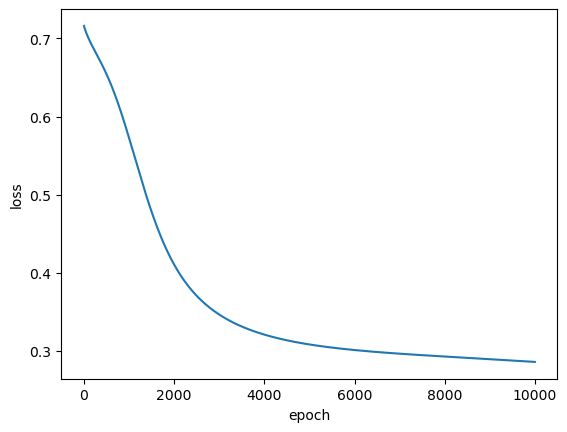

In [52]:
plt.figure()
plt.plot(epoch_loss_dict_train.keys(), epoch_loss_dict_train.values())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### Confusion Matrix

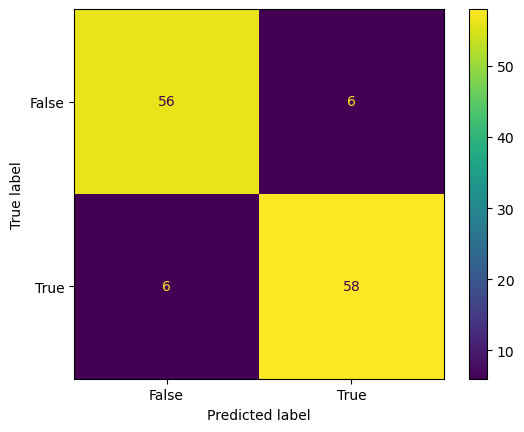

In [53]:
def confusion_matrix(y, y_pred_binary):
    cm = metrics.confusion_matrix(y, y_pred_binary)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    plt.show()


confusion_matrix(y_train, y_pred_binary_train)

## **Trying Our Model on Validation Set**

In [54]:
y_pred_val = train_model(X_val_tensor)
y_pred_binary_val = (y_pred_val.detach().numpy() > 0.5).astype(int)

### Performance Metrics

In [55]:
accuracy_val, precision_val, recall_val, f1_val = perf_metrics(y_val, y_pred_binary_val)

print("Accuracy on validation set:", accuracy_val)
print("Precision on validation set:", precision_val)
print("Recall on validation set:", recall_val)
print("F1-score on validation set:", f1_val)

Accuracy on validation set: 0.7818181818181819
Precision on validation set: 0.8275862068965517
Recall on validation set: 0.7741935483870968
F1-score on validation set: 0.7999999999999999


### Confusion Matrix

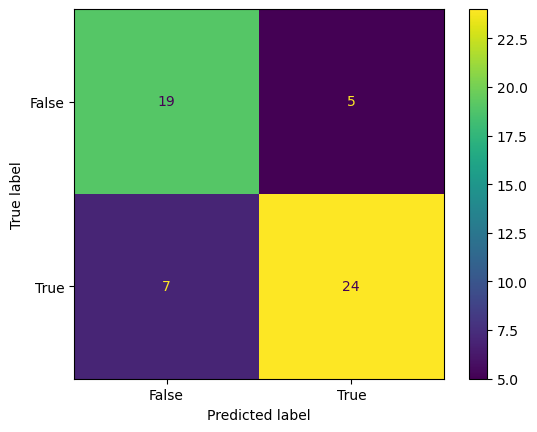

In [56]:
confusion_matrix(y_val, y_pred_binary_val)

### Adding Regularization

In [57]:
optimizer_reg = SGD(train_model.parameters(), lr=0.01, weight_decay = 1e-2)

In [58]:
epoch_list = []
loss_list = []
 
for epoch in range(10000):
    epoch_list.append(epoch)
    y_pred = my_model(X_train_tensor)
    loss = loss_cal(y_pred, y_train_tensor)
    loss_list.append(loss.item())
    optimizer_reg.zero_grad()
    loss.backward()
    optimizer_reg.step()


NameError: name 'my_model' is not defined

In [ ]:
plt.figure()
plt.plot(epoch_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [ ]:
y_pred_test = my_model(X_test_tensor)
y_pred_test_hard = torch.where(y_pred_test > 0.5, 1, 0)
correct = torch.where(y_pred_test_hard == y_test_tensor, 1, 0)
accuracy = float(torch.sum(correct) / y_test.shape[0])
print("accuracy:", accuracy)

In [ ]:
cm = metrics.confusion_matrix(y_test_tensor, y_pred_test_hard)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()